## **基于贝叶斯网络和条件互信息的独立性判断与检验**

#### **一、用于测试的数据集描述**

$$
\begin{aligned}
    x_1 &\sim \rm{Normal}(0, 1) \\
    x_2 &\sim \rm{Normal}(0, 1) \\
    z &\sim \rm{Normal}(0, 1)  \\
    e_1 &\sim \rm{Uniform}(0, 1e^{-6}) \\
    e_2 &\sim \rm{Uniform}(0, 1e^{-6}) \\
\end{aligned}
$$

$$
\rm{M1}: \left\{
\begin{aligned}
    x &= x_1 + z + e_1 \\
    y &= x_2 + z + e_2 \\
\end{aligned}
\right. 
$$

$$
\rm{M2}: \left\{
\begin{aligned}
    x &= x_1 + z + e_1 \\
    y &= z^2 + e_2 \\
\end{aligned}
\right.
$$

$$
\rm{M3}: \left\{
\begin{aligned}
    x &= x_1 + z + e_1 \\
    y &= 0.5 \cdot \sin(\pi \cdot x_1) + z + e_2 \\
\end{aligned}
\right.
$$

$$
\rm{M4}: \left\{
\begin{aligned}
    x &= x_1 + z + e_1 \\
    y &= x_1 + x_2 + z + e_2 \\
\end{aligned}
\right.
$$

#### **二、基于贝叶斯网络的变量独立性判断**

以上数据集M1 ~ M4中各变量间的因果关系（即贝叶斯网络）如下图所示。注意$x_1$、$x_2$、$z$、$e_1$和$e_2$为独立的随机因变量，而$x$和$y$为结果。  
根据贝叶斯网络中的**D分离原理**[^1]可对x和y关于z的条件独立性进行判断，结果如最后一行图所示。其中，M1和M2中x和y关于z条件独立，而在M3和M4中x和y不关于z条件独立。

<img src="./数据关系图.png" width=1000>

#### **三、计算验证**

准备工作

In [8]:
import seaborn as sns
import pandas as pd
import arviz as az
import numpy as np
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt
from statistical_significance.surrog_indep_test import exec_surrog_indep_test


def _normalize(x: np.ndarray):
    x = x.copy()
    x_min, x_max = np.min(x), np.max(x)
    return (x - x_min) / (x_max - x_min)


def gen_data(func: str, N: int):
    """产生数据"""
    x1 = np.random.normal(0, 1, N)
    x2 = np.random.normal(0, 1, N)
    e1 = np.random.random(N) * 1e-6
    e2 = np.random.random(N) * 1e-6
    z = np.random.normal(0, 1, N)
    
    if func == "M1":
        x = x1 + z + e1
        y = x2 + z + e2
    elif func == "M2":
        x = x1 + z + e1
        y = np.power(z, 2) + e2
    elif func == "M3":
        x = x1 + z + e1
        y = 0.5 * np.sin(x1 * np.pi) + z + e2
    elif func == "M4":
        x = x1 + z + e1
        y = x1 + x2 + z + e2
    
    return _normalize(x), _normalize(y), _normalize(z)

首先对以上四个数据集中样本进行可视化。  
每张子图中，各颜色代表位于不同 $z$ 分位数层级 $l_{z,i}$ 中的 $x$、$y$ 样本点。比如黑色散点表示在层 $l_{x, 0}$ 即 $z$ 小于其0.1分位数 $z_{0.1}$ 时 $x$ 和 $y$ 的分布。  
可以结合以上因果分析验证
* 在M1和M2各分位数层级 $l_{z,i} (0 \leq i \leq 5)$中，条件独立即 $p(x,y|z \in l_{z, i})=p(x|z \in l_{z, i}) \cdot p(y|z \in l_{z, i})$ 成立；
* 在M3和M4各分位数层级 $l_{z,i} (0 \leq i \leq 5)$中，非条件独立即 $p(x,y|z \in l_{z, i})\neq p(x|z \in l_{z, i}) \cdot p(y|z \in l_{z, i})$ 成立。

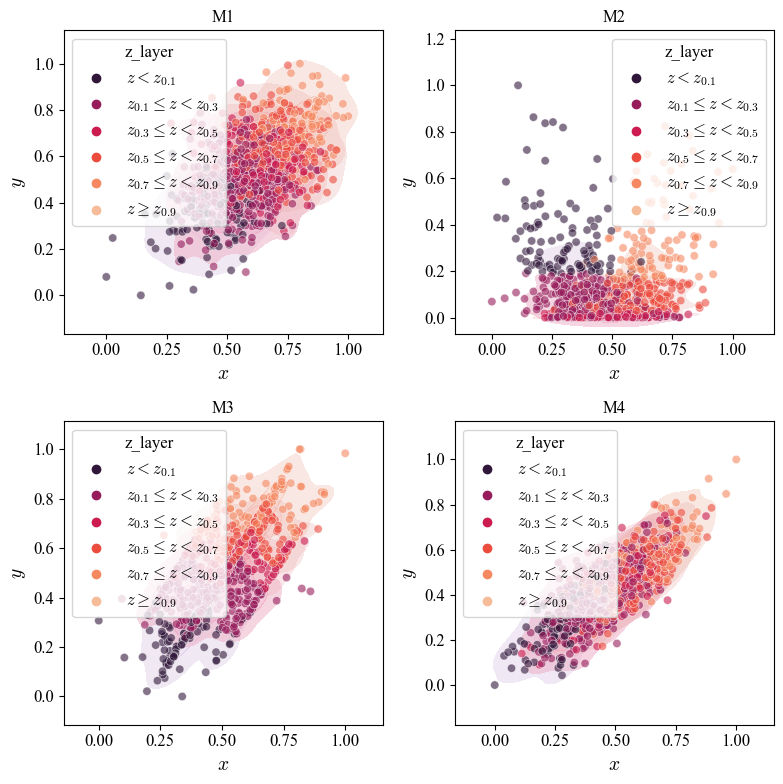

In [9]:
funcs = ["M1", "M2", "M3", "M4"]
N = 1000
colors = ["blue", "orange", "green", "red", "grey", "cyan"]
legends = [
    r"$z < z_{0.1}$",
    r"$z_{0.1} \leq z < z_{0.3}$", r"$z_{0.1} \leq z < z_{0.3}$",
    r"$z_{0.3} \leq z < z_{0.5}$", r"$z_{0.5} \leq z < z_{0.7}$",
    r"$z_{0.7} \leq z < z_{0.9}$", r"$z \geq z_{0.9}$"]

_, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, func in enumerate(funcs):
    x, y, z = gen_data(func, N)
    data = pd.DataFrame(np.c_[x, y, z], columns=["x", "y", "z"])
    
    qs = np.quantile(z, (0.1, 0.3, 0.5, 0.7, 0.9))
    
    def _deter_z_layer(z, qs):
        if z < qs[0]:
            return 0
        else:
            if z >= qs[-1]:
                return 5
            else:
                for i in range(4):
                    if (qs[i] <= z) & (z < qs[i + 1]):
                        return i + 1
    
    data["z_layer"] = data["z"].apply(lambda z: legends[_deter_z_layer(z, qs)])
    
    ax = axs[i // 2, i % 2]
    ax.set_title(func)
    sns.kdeplot(
        x="x", y="y", data=data, hue="z_layer", hue_order=legends, shade=True, levels=5,
        palette="rocket", alpha=0.3, gridsize=50, common_grid=False, ax=ax, zorder=-1)
    sns.scatterplot(
        x="x", y="y", data=data, hue="z_layer", hue_order=legends, ax=ax, zorder=1, alpha=0.6,
        palette="rocket", marker="o", sizes=8)
    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
plt.tight_layout()

接下来，采用本项目中基于代用数据和条件互信息CMI-GIEF的独立性检验算法对以上四个数据集中 $x$ 和 $y$ 关于 $z$ 的条件独立性进行计算判断：

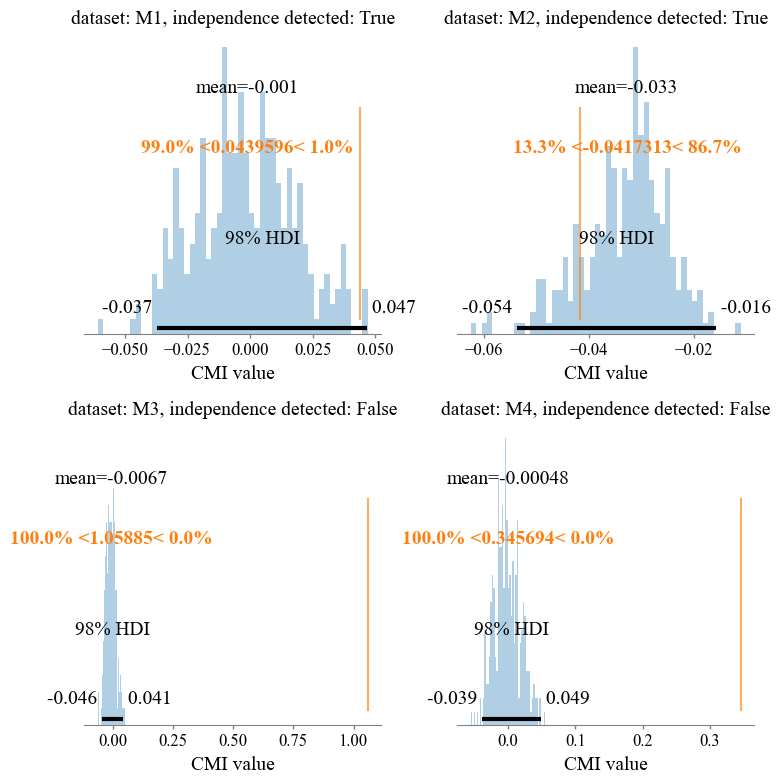

In [10]:
method = "CMI-GIEF"
rounds = 300
alpha = 0.01

_, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, func in enumerate(funcs):
    x, y, z = gen_data(func, N)
    assoc, (p, indep, assocs_srg) = exec_surrog_indep_test(
        x, y, method, z=z, xtype="c", ytype="c", ztype="c", rounds=rounds, alpha=alpha)

    # 画图
    ax = axs[i // 2, i % 2]
    az.plot_posterior(
        {f"{method}_Surrog": assocs_srg}, 
        kind="hist",
        bins=50,
        ref_val=assoc,
        hdi_prob=1 - alpha * 2,
        ax=ax)
    ax.set_title(f"dataset: {func}, independence detected: {indep}", fontsize=14)
    ax.set_xlabel("CMI value")
plt.tight_layout()

每张子图对应于一个数据集，其中蓝色直方图显示了基于代用数据获得的对应条件独立时的CMI-GIEF值背景分布，黄色竖线则表示实际样本所得的条件互信息值。其他参数说明请见arviz文档[^2]  
如果黄色竖线位于黑色横线所标记的区间中，则表示实际样本中  $x$ 和 $y$ 关于 $z$ 条件独立；否则，$x$ 和 $y$ 不关于 $z$ 条件独立。  
可以看出，基于代用数据的CMI-GIEF认为M1和M2中的 $x$ 和 $y$ 关于 $z$ 条件独立，而在M3和M4中的数据则不满足条件独立。该结论与上述基于贝叶斯网络的判断结果一致。

#### **参考材料**

[^1] https://sites.stat.washington.edu/mmp/courses/535/fall11/Handouts/l4-bayes-net-decomp.pdf  
[^2] https://python.arviz.org/en/stable/